In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datadata import utils
from prevision import *
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
input_sequence_length=14
output_sequence_length=7
df_all,x,y=getAllDataFromCSV()

In [3]:
df_all

,vente,apparent_temperature_max,apparent_temperature_min,sunset,uv_index_max,rain_sum,showers_sum,snowfall_sum,precipitation_hours,attendance_concerts,...,day_3,day_4,day_5,day_6,vacance,ferie,match_mma,match_nba,match_nfl,match_nhl
date,,,,,,,,,,,,,,,,,,,,,
2023-09-15,12222.69,20.1,8.0,19.10,5.40,0.00,0.0,0.0,0.0,0,...,False,True,False,False,0,False,0,0,0,0
2023-09-14,11244.54,14.5,11.4,19.13,3.90,0.00,0.0,0.0,0.0,0,...,True,False,False,False,0,False,0,0,0,0
2023-09-13,6514.32,23.4,15.2,19.17,4.75,36.75,0.0,0.0,4.0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-12,5708.35,23.9,14.5,19.18,4.55,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-11,3031.55,23.4,15.5,19.22,5.65,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-15,4655.16,3.4,-6.6,18.33,2.80,1.70,0.0,0.0,4.0,0,...,False,False,False,False,0,False,0,0,0,0
2023-02-14,7026.25,0.6,-6.7,18.32,3.45,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,0,0,0,1
2023-02-13,3152.95,-0.0,-10.6,18.28,3.60,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,0,0,0,0


In [4]:
class WindowGenerator():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=7):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length], self.Y[idx:idx + self.input_sequence_length][:, None]),1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y

def split_data_based_on_duration(data, duration_months):
    last_date = data['date'].max()
    cutoff_date = last_date - pd.DateOffset(months=duration_months)
    train_data = data[data['date'] <= cutoff_date]
    validation_data = data[data['date'] > cutoff_date]
    return train_data, validation_data

def getXY(data,input_sequence_length=14, output_sequence_length=7):
    x=data.drop(['date','vente'],axis=1).values
    y=data['vente'].values
    win=WindowGenerator(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1])
    return newX,newY


# traning & fine-tuning Ilyas' model

In [5]:
sales_data=df_all.reset_index()
train_data_3mo, validation_data_3mo = split_data_based_on_duration(sales_data, 3)
train_data_3mo.reset_index(drop=True, inplace=True)
validation_data_3mo.reset_index(drop=True, inplace=True)


X_train,Y_train=getXY(train_data_3mo)
X_test,Y_test=getXY(validation_data_3mo)

param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.05, 0.31, 0.05),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42,eval_metric='rmse')
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=100, scoring='neg_mean_squared_error', cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

## getting best model stats

Validation RMSE: 2736.8453019348467
Validation MAE: 2016.946080012245
best params
 {'subsample': 0.9999999999999999, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999}


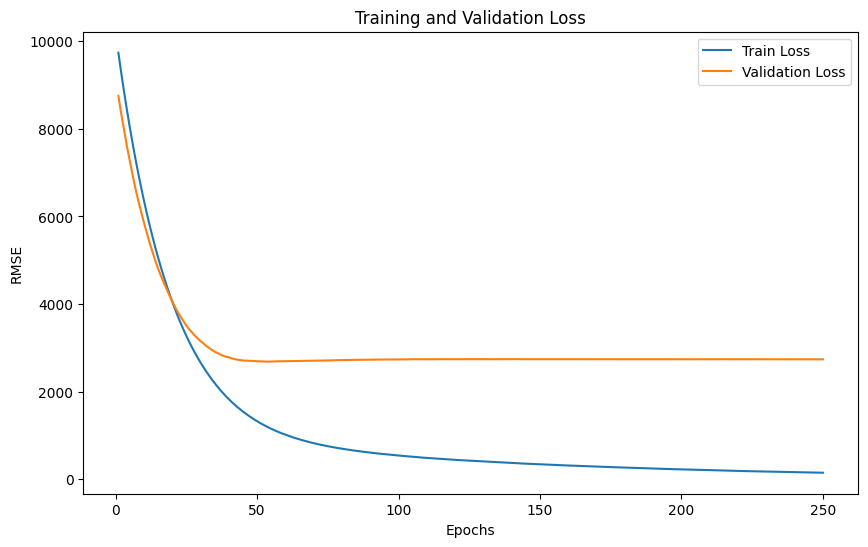

In [7]:
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
val_mae = mean_absolute_error(Y_test, val_preds)
print('Validation RMSE:', val_rmse)
print('Validation MAE:', val_mae)
print('best params\n',random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result_XGBOOST(eval_results)

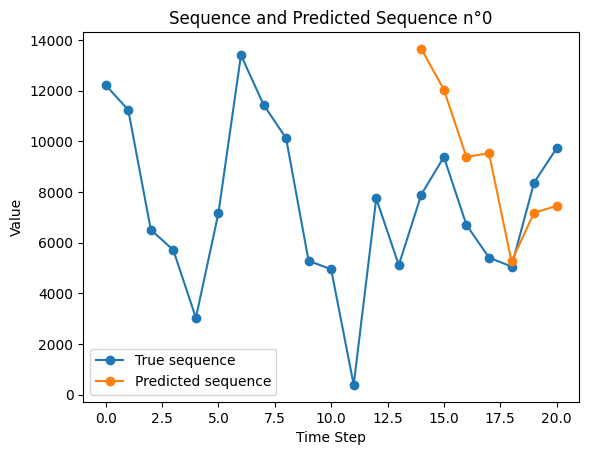

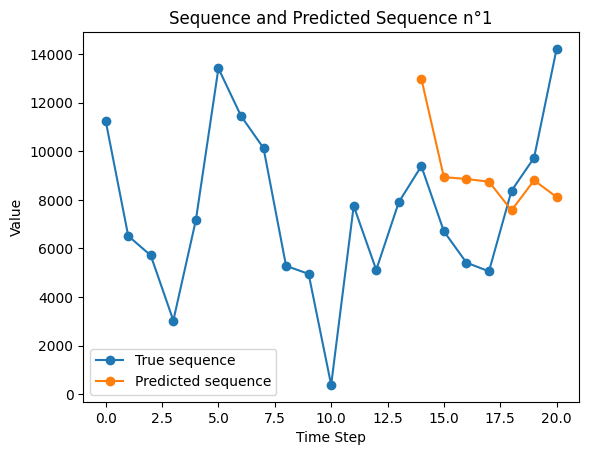

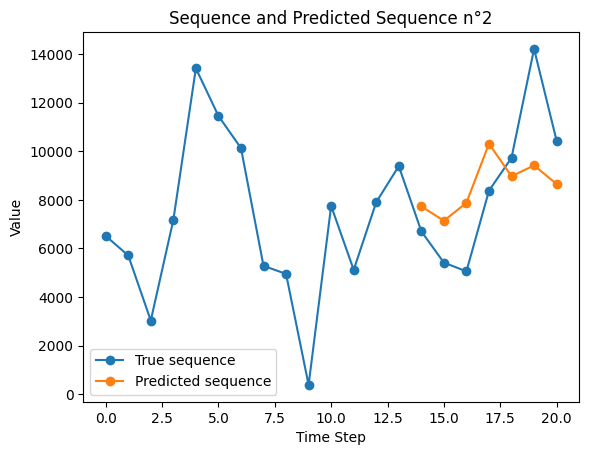

In [8]:
show_test(X_test,Y_test,res,input_sequence_length,output_sequence_length)

Best root_mean_squared_error: 2755.551513671875
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05190083171290592, 'subsample': 0.7125830104304639, 'colsample_bytree': 0.963833648455322}


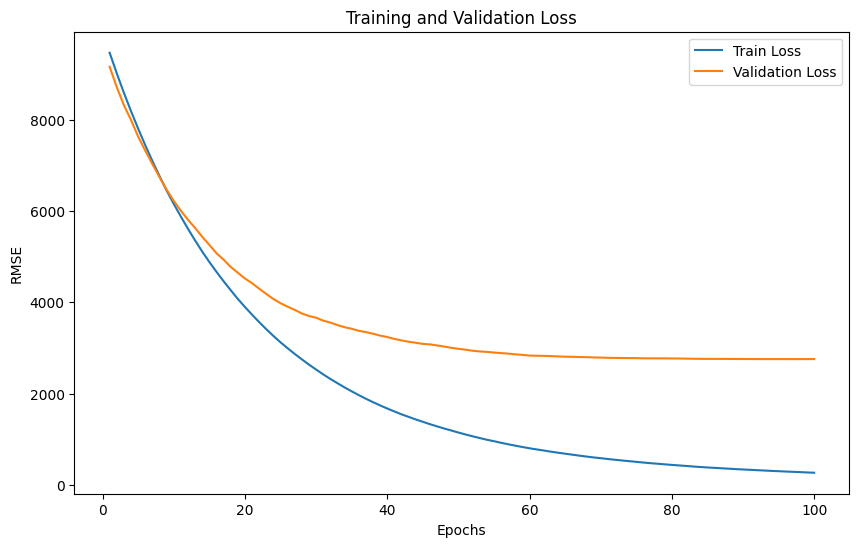

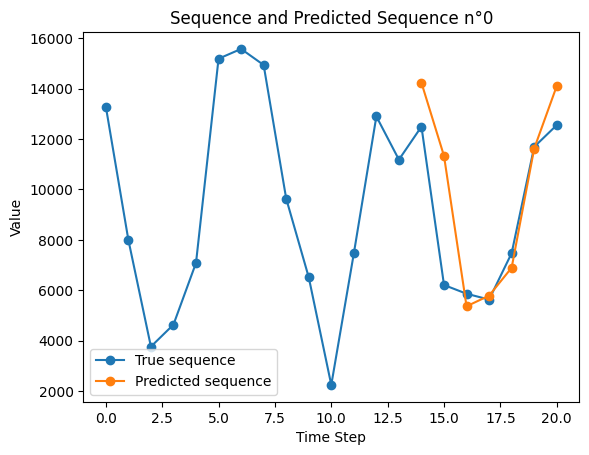

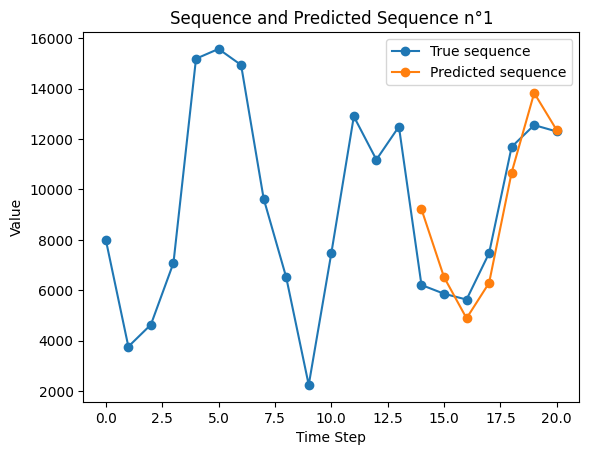

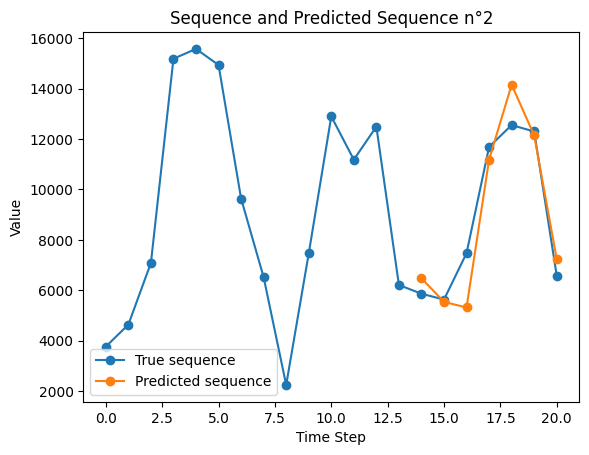

file saved at /Users/carlos/PycharmProjects/dionysos/prevision/results/Xgboost/saves/Xgboost_10.pkl


In [9]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=input_sequence_length,
                      output_sequence_length=output_sequence_length,verbose_mod = 100, input_size=28)
a = Model(options)
b = DataLoader(options)
a.fineTuneRnn(b, None,100)

In [ ]:
def feature_importance(best_model, X_train):
    """
    Calcule et affiche l'importance des fonctionnalités du modèle.

    Arguments:
    - best_model : meilleur modèle entraîné
    - X_train : données d'entraînement (features)
    """
    # Obtenir l'importance des fonctionnalités
    importance = best_model.feature_importances_
    print(len(importance))
    # Triez les fonctionnalités par importance décroissante
    feature_names = df_all.columns.tolist()
    print(feature_names)
    
    # Regrouper l'importance des day_0, day_1, day_2, day_3, day_4, day_5, day_6 en une seule colonne day
    day_0_index = feature_names.index('day_0')
    day_importance = np.sum(importance[day_0_index:day_0_index + 7])
    importance[day_0_index] = day_importance
    importance = np.delete(importance, range(day_0_index + 1, day_0_index + 7))
    feature_names = np.delete(feature_names, range(day_0_index + 1, day_0_index + 7))
    feature_names[day_0_index] = 'day'

    # Lister les fonctionnalités par importance décroissante
    feature_names = feature_names.tolist()
    feature_names = np.array(feature_names)
    indices = np.argsort(importance)[::-1]

    # Tracer le graphique de l'importance des fonctionnalités
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[indices], tick_label=feature_names[indices].tolist())
    plt.xticks(rotation=90)
    plt.xlabel('Fonctionnalités')
    plt.ylabel('Importance')
    plt.title('Importance des fonctionnalités')
    plt.show()

feature_importance(best_model, X_train)